In [1]:
pip install medmnist timm torch torchvision -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from timm import create_model
import torch.nn as nn
import torch.optim as optim
import os
import requests
import zipfile
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import medmnist


/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.empty_cache()


In [5]:
class NumpyDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        image = (image * 255).astype(np.uint8)
        label = int(label) # int label 1d

        # CHW
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [18]:
path = '/home/dime/Desktop/Pre-thesis/data/bloodmnist_224'

In [7]:
from collections import Counter

def compute_class_counts(labels_path):
    labels = np.load(labels_path).flatten()  
    return dict(Counter(labels))  

In [32]:
random_seed = 42

img_size=224

batch_size = 32

epochs = 10
num_epochs = 10

learning_rate = 0.001  

num_classes = 8 #BloodMNIST

In [9]:
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])

In [19]:
def load_datasets(batch_size=batch_size, img_size=img_size):
    train_dataset = NumpyDataset(os.path.join(path, 'train_images.npy'), os.path.join(path, 'train_labels.npy'), transform)
    val_dataset = NumpyDataset(os.path.join(path, 'val_images.npy'), os.path.join(path, 'val_labels.npy'), transform)
    test_dataset = NumpyDataset(os.path.join(path, 'test_images.npy'), os.path.join(path, 'test_labels.npy'), transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [20]:
train_class_counts = compute_class_counts(os.path.join(path, 'train_labels.npy'))
val_class_counts = compute_class_counts(os.path.join(path, 'val_labels.npy'))
test_class_counts = compute_class_counts(os.path.join(path, 'test_labels.npy'))

print('Train class counts:', train_class_counts)
print('Val class counts:', val_class_counts)
print('Test class counts:', test_class_counts)

Train class counts: {7: 1643, 3: 2026, 6: 2330, 2: 1085, 1: 2181, 5: 993, 0: 852, 4: 849}
Val class counts: {4: 122, 0: 122, 7: 235, 6: 333, 1: 312, 5: 143, 2: 155, 3: 290}
Test class counts: {3: 579, 0: 244, 1: 624, 6: 666, 5: 284, 2: 311, 4: 243, 7: 470}


In [21]:
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)

        self.vit.head = nn.Sequential(
            nn.Dropout(0.1),
            self.vit.head
        )

    def forward(self, x):
        return self.vit(x)

In [22]:
def plot_metrics(metrics_log):
    epochs = range(1, len(metrics_log["train_loss"]) + 1)

    # Plot loss
    plt.figure()
    plt.plot(epochs, metrics_log["train_loss"], label="Train Loss")
    plt.plot(epochs, metrics_log["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, metrics_log["train_accuracy"], label="Train Accuracy")
    plt.plot(epochs, metrics_log["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.show()

    # Plot F1 score
    plt.figure()
    plt.plot(epochs, metrics_log["train_f1"], label="Train F1 Score")
    plt.plot(epochs, metrics_log["val_f1"], label="Validation F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs Epochs")
    plt.legend()
    plt.show()

In [24]:
def train_model(model, train_loader, val_loader, device, num_epochs=num_epochs, lr=learning_rate):
    metrics_log = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_f1": []    
    }

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.cuda.amp.GradScaler()

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels, all_preds = [], []

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        val_labels, val_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_loss /= len(val_loader)

        metrics_log["train_loss"].append(train_loss)
        metrics_log["train_accuracy"].append(train_accuracy)
        metrics_log["train_f1"].append(train_f1)
        metrics_log["val_loss"].append(val_loss)
        metrics_log["val_accuracy"].append(val_accuracy)
        metrics_log["val_f1"].append(val_f1)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
    
    print(f"  Final Train Loss: {metrics_log['train_loss'][-1]:.4f}")
    print(f"  Final Train Accuracy: {metrics_log['train_accuracy'][-1]:.4f}")
    print(f"  Final Train F1: {metrics_log['train_f1'][-1]:.4f}")
    print(f"  Final Val Loss: {metrics_log['val_loss'][-1]:.4f}")
    print(f"  Final Val Accuracy: {metrics_log['val_accuracy'][-1]:.4f}")
    print(f"  Final Val F1: {metrics_log['val_f1'][-1]:.4f}")
    plot_metrics(metrics_log)
    return metrics_log

Training Epoch 1/10:   0%|          | 0/374 [00:00<?, ?it/s]/tmp/ipykernel_52826/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
Validating:   0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipykernel_52826/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent a

Epoch [1/10]:
  Train Loss: 2.2752, Accuracy: 0.1735, F1: 0.1480
  Val Loss: 2.0794, Accuracy: 0.1373, F1: 0.0331


Training Epoch 2/10:   0%|          | 0/374 [00:00<?, ?it/s]/tmp/ipykernel_52826/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [2/10]:
  Train Loss: 2.0359, Accuracy: 0.1795, F1: 0.1331
  Val Loss: 2.0176, Accuracy: 0.1857, F1: 0.0891


Training Epoch 3/10:   0%|          | 0/374 [00:00<?, ?it/s]/tmp/ipykernel_52826/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [3/10]:
  Train Loss: 2.0155, Accuracy: 0.1863, F1: 0.1287
  Val Loss: 2.0117, Accuracy: 0.1694, F1: 0.0491


Training Epoch 4/10:   0%|          | 0/374 [00:00<?, ?it/s]/tmp/ipykernel_52826/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [4/10]:
  Train Loss: 2.0113, Accuracy: 0.1886, F1: 0.1298
  Val Loss: 2.0078, Accuracy: 0.1822, F1: 0.0562


Training Epoch 5/10:   0%|          | 0/374 [00:00<?, ?it/s]/tmp/ipykernel_52826/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [5/10]:
  Train Loss: 2.0101, Accuracy: 0.1850, F1: 0.1277
  Val Loss: 2.0042, Accuracy: 0.1834, F1: 0.0887


Training Epoch 6/10:   0%|          | 0/374 [00:00<?, ?it/s]/tmp/ipykernel_52826/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [6/10]:
  Train Loss: 2.0068, Accuracy: 0.1835, F1: 0.1206
  Val Loss: 2.0080, Accuracy: 0.1945, F1: 0.0633


Training Epoch 7/10:   0%|          | 0/374 [00:00<?, ?it/s]/tmp/ipykernel_52826/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [7/10]:
  Train Loss: 2.0040, Accuracy: 0.1919, F1: 0.1078
  Val Loss: 1.9997, Accuracy: 0.1822, F1: 0.0562


Training Epoch 8/10:   0%|          | 0/374 [00:00<?, ?it/s]/tmp/ipykernel_52826/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [8/10]:
  Train Loss: 2.0035, Accuracy: 0.1914, F1: 0.1120
  Val Loss: 2.0050, Accuracy: 0.1945, F1: 0.0633


Training Epoch 9/10:   0%|          | 0/374 [00:00<?, ?it/s]/tmp/ipykernel_52826/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [9/10]:
  Train Loss: 1.9948, Accuracy: 0.2010, F1: 0.1071
  Val Loss: 1.9909, Accuracy: 0.2009, F1: 0.0839


Training Epoch 10/10:   0%|          | 0/374 [00:00<?, ?it/s]/tmp/ipykernel_52826/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [10/10]:
  Train Loss: 1.9796, Accuracy: 0.2107, F1: 0.1217
  Val Loss: 1.9617, Accuracy: 0.2167, F1: 0.1013
  Final Train Loss: 1.9796
  Final Train Accuracy: 0.2107
  Final Train F1: 0.1217
  Final Val Loss: 1.9617
  Final Val Accuracy: 0.2167
  Final Val F1: 0.1013


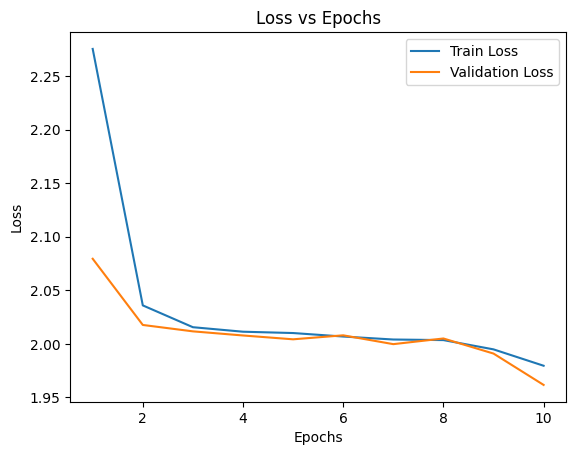

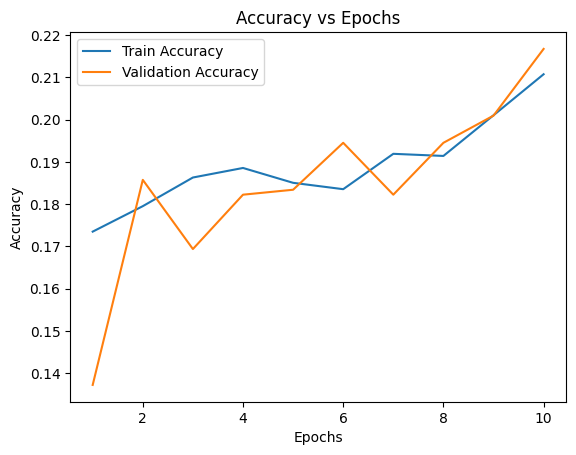

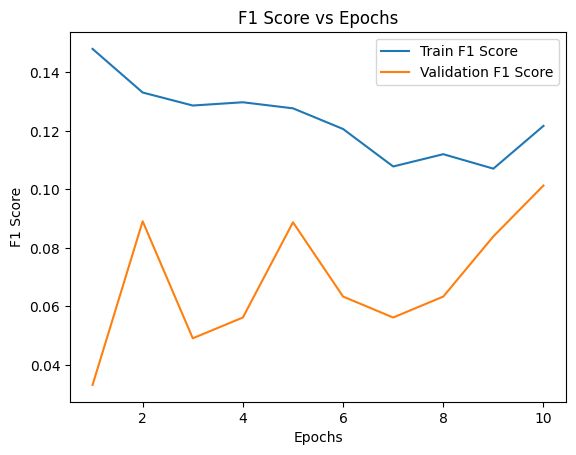

CPU times: user 2h 3min 12s, sys: 5.02 s, total: 2h 3min 17s
Wall time: 12min 9s


In [34]:
%%time

if __name__ == "__main__":
    train_loader, val_loader, test_loader = load_datasets(batch_size, img_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViTModel(num_classes=num_classes)

    train_model(model, train_loader, val_loader, device, num_epochs, learning_rate)

In [35]:
torch.save(model.state_dict(), '/home/dime/Desktop/Pre-thesis/data/bloodmnist_224/vit_model_blood.pth')

In [20]:
torch.cuda.empty_cache()

## 10%

In [16]:
def subset_dataset_percentage(dataset, labels_path, percentage=10, seed=42):
    random.seed(seed)
    labels = np.load(labels_path).flatten()
    class_indices = defaultdict(list)

    for idx, label in enumerate(labels):
        class_indices[label].append(idx)
    
    subset_indices = []
    for indices in class_indices.values():
        subset_size = max(1, len(indices) * percentage // 100)
        subset_indices.extend(random.sample(indices, subset_size))
    
    return Subset(dataset, subset_indices)

def load_data_subset(batch_size=32, img_size=224):
    train_dataset = NumpyDataset(os.path.join(path, 'train_images.npy'), os.path.join(path, 'train_labels.npy'), transform)
    val_dataset = NumpyDataset(os.path.join(path, 'val_images.npy'), os.path.join(path, 'val_labels.npy'), transform)
    test_dataset = NumpyDataset(os.path.join(path, 'test_images.npy'), os.path.join(path, 'test_labels.npy'), transform)

    train_subset = subset_dataset_percentage(train_dataset, os.path.join(path, 'train_labels.npy'), percentage=10, seed=42)
    val_subset = val_dataset
    test_subset = test_dataset

    train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader_subset = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader_subset = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader_subset, val_loader_subset, test_loader_subset   

In [17]:
num_epochs = 1000
learning_rate = 0.0001

def train_subset_model(model, train_loader, val_loader, device, num_epochs=num_epochs, lr=learning_rate):
    metrics_log = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_f1": []    
    }

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.cuda.amp.GradScaler()

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels, all_preds = [], []

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        val_labels, val_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_loss /= len(val_loader)

        metrics_log["train_loss"].append(train_loss)
        metrics_log["train_accuracy"].append(train_accuracy)
        metrics_log["train_f1"].append(train_f1)
        metrics_log["val_loss"].append(val_loss)
        metrics_log["val_accuracy"].append(val_accuracy)
        metrics_log["val_f1"].append(val_f1)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
    
    print(f"  Final Train Loss: {metrics_log['train_loss'][-1]:.4f}")
    print(f"  Final Train Accuracy: {metrics_log['train_accuracy'][-1]:.4f}")
    print(f"  Final Train F1: {metrics_log['train_f1'][-1]:.4f}")
    print(f"  Final Val Loss: {metrics_log['val_loss'][-1]:.4f}")
    print(f"  Final Val Accuracy: {metrics_log['val_accuracy'][-1]:.4f}")
    print(f"  Final Val F1: {metrics_log['val_f1'][-1]:.4f}")
    plot_metrics(metrics_log)
    return metrics_log

In [ ]:
if __name__ == "__main__":

    train_subset_loader, val_subset_loader, test_subset_loader = load_data_subset(batch_size, img_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViTModel(num_classes=num_classes)

    train_subset_model(model, train_subset_loader, val_subset_loader, device, num_epochs, learning_rate)

NameError: name 'load_data_subset' is not defined